In [136]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import nltk
import numpy as np
from argparse import ArgumentParser
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 
rcParams['axes.labelpad'] = 15
%matplotlib inline

In [2]:
os.chdir('../models')
os.getcwd()

'/scratch/jmw784/nlp-multinli/models'

In [3]:
from models import ConcatModel, CosineModel, ESIM

sys.path.append('../utilities')
from tokenizers import custom_tokenizer
from utils import get_dataset, get_args

# Loading arguments

If you want to get the config from the slurm file

In [4]:
F = open('../slurm/main.slurm','r')
options = F.read().split('main.py ')[1].strip('\n')

Else, if you want to paste the args here:

In [5]:
options = '--cuda --save_model --model_type ESIM --max_vocab_size 15000 --n_epochs 15 --batch_size 64 --d_embed 300 --d_hidden 200 --n_layers 1 --lr 0.001 --dropout_emb 0.2 --dropout_rnn 0.0 --dropout_mlp 0.5 --word_vectors glove.6B.300d --bidir --dev_every 1550'

In [6]:
options = options.split(' ')
sys.argv = options
args = get_args()

In [7]:
args

Namespace(batch_size=64, bidir=True, cuda=False, d_embed=300, d_hidden=200, dev_every=1550, dropout_emb=0.2, dropout_mlp=0.5, dropout_rnn=0.0, load_model='', lr=0.001, max_vocab_size=15000, model_type='ESIM', n_epochs=15, n_layers=1, n_linear_layers=3, save_model=True, sentence_len=None, val_set='val_matched', word_vectors='glove.6B.300d')

# Build datasets

In [8]:
nltk_path = os.getcwd() + '/nltk_data'
nltk.download('punkt', download_dir=nltk_path)
nltk.data.path.append(nltk_path)

[nltk_data] Downloading package punkt to /scratch/jmw784/nlp-
[nltk_data]     multinli/models/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
text_field = data.Field(tokenize=custom_tokenizer,
                        fix_length=args.sentence_len,
                        unk_token='<**UNK**>')
label_field = data.Field(sequential=False, unk_token=None)

train = get_dataset(text_field, label_field, 'train')
val = get_dataset(text_field, label_field, args.val_set)

text_field.build_vocab(train, max_size=args.max_vocab_size)
label_field.build_vocab(train, val)

Creating Train Dataset
Creating Val_Matched Dataset


In [10]:
if args.word_vectors:
    text_field.vocab.load_vectors(args.word_vectors)

In [11]:
def sort_key(ex):
    return data.interleave_keys(len(ex.premise), len(ex.hypothesis))

In [39]:
device = -1
train_iter, val_iter = data.BucketIterator.splits((train, val),
                                            batch_size=args.batch_size,
                                            shuffle = False,
                                            sort = True,
                                            sort_key = sort_key,
                                            device=device)

In [80]:
class_map = {0: 'entailment',
           1: 'contradiction',
           2: 'neutral'}

# Load model

In [13]:
saved_model = 'Model_ESIM_acc_72.3790_epoch_5_model.pt'
model = torch.load('../saved_models/' + saved_model)

In [14]:
model

ESIM (
  (embed): Embedding(15002, 300)
  (emb_drop): Dropout (p = 0.2)
  (dropout): Dropout (p = 0.5)
  (mlp): Linear (1600 -> 200)
  (cl): Linear (200 -> 3)
  (premise): LSTM(300, 200, bidirectional=True)
  (hypothesis): LSTM(300, 200, bidirectional=True)
  (v1): LSTM(1600, 200, bidirectional=True)
  (v2): LSTM(1600, 200, bidirectional=True)
)

In [15]:
def get_batch(data, batch_size, batch_size_fn=lambda new, count, sofar: count):
    """Yield elements from data in chunks of batch_size."""
    minibatch, size_so_far = [], 0
    for ex in data:
        minibatch.append(ex)
        size_so_far = batch_size_fn(ex, len(minibatch), size_so_far)
        if size_so_far == batch_size:
            yield minibatch
            minibatch, size_so_far = [], 0
        elif size_so_far > batch_size:
            yield minibatch[:-1]
            minibatch, size_so_far = minibatch[-1:], batch_size_fn(ex, 1, 0)
    if minibatch:
        yield minibatch

In [168]:
def evaluate(iterator, model):
    real_iter = get_batch(iterator.data(), args.batch_size)
    
    model.eval()
    n_correct = 0
    predictions = []
    labels = []
    
    premises = []
    hypothesises = []
    real_labels = []
    
    for batch, real_batch in zip(iterator, real_iter):
        
        real_batch.reverse()
        out = model(batch)
        batch_predict = torch.max(out, 1)[1].view(batch.label.size()).data
        batch_label = batch.label.data
        n_correct += (batch_predict == batch_label).sum()
        predictions.extend(batch_predict.tolist())
        labels.extend(batch_label.tolist())
        
        premises.extend([x.premise for x in real_batch])
        hypothesises.extend([x.hypothesis for x in real_batch])
        real_labels.extend([x.label for x in real_batch])
                        
    return n_correct,\
           np.array(predictions), np.array(labels),\
           np.array(premises), np.array(hypothesises), np.array(real_labels)

In [169]:
def plot_confusion_matrix(true_values, predicted_values,
                          class_map = class_map,
                          classes = [0, 1, 2], 
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(true_values, predicted_values, labels = classes)

    fig, ax = plt.subplots(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=16, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [class_map[i] for i in classes])
    plt.yticks(tick_marks, [class_map[i] for i in classes])

    if normalize:
        cm = np.around(100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{0}%'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size='large')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.yaxis.label.set_size(14)
    ax.xaxis.label.set_size(14)


In [170]:
n_correct, predictions, labels, premises, hypotheses, real_labels = evaluate(val_iter, model)

In [171]:
accuracy = n_correct / len(val_iter.dataset) * 100
print("Accuracy: {0}".format(accuracy))

Accuracy: 72.37901171676006


Normalized confusion matrix
[[ 76.8    8.65  14.54]
 [ 12.45  73.36  14.19]
 [ 17.55  16.01  66.44]]


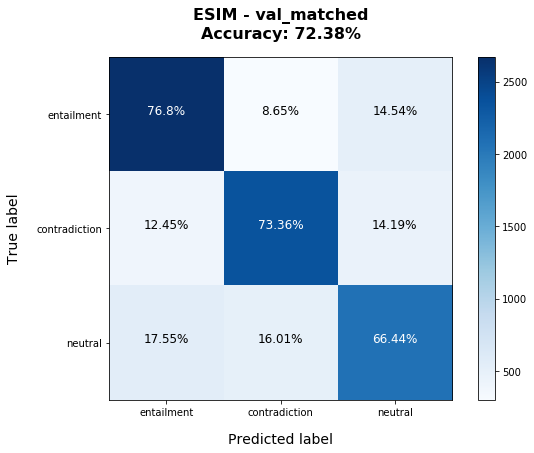

In [172]:
 plot_confusion_matrix(labels, predictions, title='%s - %s\nAccuracy: %0.2f%%'
                                                  % (args.model_type, args.val_set, accuracy))

In [198]:
def print_samples(label, prediction, samples = 5):
    idx = np.logical_and(labels == label, predictions == prediction)
    n = np.sum(idx)
    
    selection = np.random.choice(range(n), size=samples)
    
    p = premises[idx][selection]
    h = hypotheses[idx][selection]
    
    print('TRUE LABEL: %s\nPREDICTION: %s\n' % (class_map[label], class_map[prediction]))
    
    for i in range(samples):
        print('Sample %s' % (i+1))
        print('Premise: ' + ' '.join(p[i]))
        print('Hypothesis: ' + ' '.join(h[i]))
        print('-------------------------------------------------------\n')

In [199]:
for i in range(2):
    for j in range(2):
        print_samples(i, j)

TRUE LABEL: entailment
PREDICTION: entailment

Sample 1
Premise: i have been visiting an old woman in the village , she explained , `` and as lawrence told me you were with monsieur poirot i thought i would call for you . ''
Hypothesis: there is an old woman in the village that i have been visiting .
-------------------------------------------------------

Sample 2
Premise: around the year 1400 , fighting over the island of singapore drove the srivijaya prince parameswara to seek refuge up the peninsula coast with his orang laut pirate friends in their small fishing village of melaka .
Hypothesis: there was fighting over singapore .
-------------------------------------------------------

Sample 3
Premise: true yeah i know it is n't that ridiculous we have cable which helps a lot
Hypothesis: it is n't that absurd ; we have cable , which is great .
-------------------------------------------------------

Sample 4
Premise: sultan abdul hamid ii ( 1876 1909 ) tried to apply absolute rule 